# Sensitivity Analysis for ABS

Author: A.Pilko <a.pilko@soton.ac.uk>

In [1]:
import pathlib

import numpy as np
import pandas as pd
import os
import sys
from pyDOE2 import *
import subprocess
import joblib as jl
import boto3
import sqlite3

In [2]:
# AWS setup
batch_client = boto3.client('batch')
s3_client = boto3.client('s3')

In [3]:
run_config_db = sqlite3.connect("aws-run-config.db")
run_config_cursor = run_config_db.cursor()
run_config_cursor.execute("CREATE TABLE IF NOT EXISTS runs(run_id, n_jobs, sim_per_job, traffic_density, timestep, surface_entrance, own_velocity)")

# 30000 sims_per_job ~= 85mins for 0.1s ts, 1e-9 td, 40m/s vel

n_jobs = 200
sims_per_job = 3000
print(f'Simulated ops: {n_jobs * sims_per_job:.1e}')

Simulated ops: 6.0e+05


### Parameters


In [5]:
## Constants
BOUNDS = '-145176.17270300398,-101964.24515822314,6569893.199178016,6595219.236650961,0,1524'
PROJ_PATH = '/home/aliaksei/PycharmProjects/sandbox/abs_tester/'
OWNPATH_PATH = PROJ_PATH + 'test_data/path.csv'
OWNPATH_PATH_LENGTH = 68818.61266545641
ALTS_PATH = PROJ_PATH + 'test_data/alts.csv'
TRACKS_PATH = PROJ_PATH + 'test_data/tracks.csv'
VELS_PATH = PROJ_PATH + 'test_data/vels.csv'
VERTS_PATH = PROJ_PATH + 'test_data/vert_rates.csv'

BINARY_NAME = '/home/aliaksei/GoProjects/abs-specific/abs-specific'
cmd_args = [BINARY_NAME, '--bounds', BOUNDS, '--simOps', '750000', '--altDataPath', ALTS_PATH,'--velDataPath', VELS_PATH, '--trackDataPath', TRACKS_PATH, '--vertRateDataPath', VERTS_PATH, '--ownPath', OWNPATH_PATH]

RESULT_DIR = PROJ_PATH + 'aws_results'

### Design of Experiments

In [6]:
traffic_density_levels = [1e-9, 1e-11, 1e-13]
timestep_levels = [0.1, 1, 2]
# surface_entrance_levels = [0,1]
own_velocity_levels = [40, 60, 80]

# design_matrix = fullfact([len(traffic_density_levels), len(timestep_levels), len(own_velocity_levels)])
design_matrix = bbdesign(3)
def fill_dm(row):
    return traffic_density_levels[int(row[0])], timestep_levels[int(row[1])],  own_velocity_levels[int(row[2])]
design_matrix = np.apply_along_axis(fill_dm, 1, design_matrix)
design_matrix

array([[1.e-13, 2.e+00, 4.e+01],
       [1.e-11, 2.e+00, 4.e+01],
       [1.e-13, 1.e+00, 4.e+01],
       [1.e-11, 1.e+00, 4.e+01],
       [1.e-13, 1.e-01, 8.e+01],
       [1.e-11, 1.e-01, 8.e+01],
       [1.e-13, 1.e-01, 6.e+01],
       [1.e-11, 1.e-01, 6.e+01],
       [1.e-09, 2.e+00, 8.e+01],
       [1.e-09, 1.e+00, 8.e+01],
       [1.e-09, 2.e+00, 6.e+01],
       [1.e-09, 1.e+00, 6.e+01],
       [1.e-09, 1.e-01, 4.e+01],
       [1.e-09, 1.e-01, 4.e+01],
       [1.e-09, 1.e-01, 4.e+01]])

In [86]:
def run(traffic_density, timestep, own_velocity):
    # output_db_name = f'{RESULT_DIR}/out_{traffic_density:.1e}_{timestep:.1e}_{bool(surface_entrance)}.db'
    # print(' '.join(cmd_args + ['--db-path', output_db_name,'--target-density', str(traffic_density), '--timestep', str(timestep)]))
    # os.system(' '.join(cmd_args + ['--dbPath', output_db_name,'--target-density', str(traffic_density), '--timestep', str(timestep), '--surfaceEntrance', str(bool(surface_entrance)).lower()]))
    job_run = batch_client.submit_job(
        jobName='absara-run-job',
        jobQueue='absara-job-queue',
        arrayProperties={
            'size': n_jobs
        },
        jobDefinition='absara-sim-compute-fargate',
        parameters={
            "bounds": "-145176.17270300398,-101964.24515822314,6569893.199178016,6595219.236650961,0,1524",
            "target_density": str(traffic_density),
            "simOps": str(sims_per_job),
            "altDataPath": "s3://absara-inputs/QA-IoW-inputs/alts.csv",
            "velDataPath": "s3://absara-inputs/QA-IoW-inputs/vels.csv",
            "trackDataPath": "s3://absara-inputs/QA-IoW-inputs/tracks.csv",
            "vertRateDataPath": "s3://absara-inputs/QA-IoW-inputs/vert_rates.csv",
            "ownDataPath": "s3://absara-inputs/QA-IoW-inputs/path.csv",
            "ownVelocity": str(own_velocity),
            "timestep": str(timestep),
            "surfaceEntrance": "true",
            "dbPath": "s3://absara-results/QA-IoW-outputs/"
      },
    )

    run_config_cursor.execute("INSERT INTO runs VALUES (?,?,?,?,?,?,?)", [job_run['jobId'], n_jobs, sims_per_job, traffic_density, timestep, True, own_velocity])


# for row in design_matrix:
#     run(*row)
    # break

run_config_db.commit()

In [78]:
# run(*list(design_matrix[-1,:]))

In [7]:
import sqlite3
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

result_bucket = "absara-results"
result_folder = "QA-IoW-outputs/"
result_ids = []
results = []

for id in run_config_cursor.execute("SELECT run_id FROM runs").fetchall():
    run_id = id[0]
    job_num = run_config_cursor.execute(f'SELECT n_jobs FROM runs WHERE run_id="{id[0]}"').fetchone()[0]
    # print(results_key_folder)
    # print(job_num)
    out_dir = Path(RESULT_DIR, result_folder, run_id)
    if not out_dir.exists():
        out_dir.mkdir(parents=True, exist_ok=True)
        # os.makedirs(out_dir, exist_ok=True)
    for n in range(job_num):
        out_path = Path(out_dir, f'{n}-results.db')
        # print(out_path)
        if out_path.exists():
            continue
        else:
            key = f"{run_id}/{n}-results.db"
            try:
                with out_path.open('wb') as f:
                    s3_client.download_fileobj(str(result_bucket), str(key), f)
            except Exception as e:
                print(f'\nUnable to download {key}:\n{e}\n')
                out_path.unlink(missing_ok=True)


Unable to download 65486967-cfd6-48b4-a78a-a6f19e6a73d0/4-results.db:
An error occurred (404) when calling the HeadObject operation: Not Found


Unable to download 65486967-cfd6-48b4-a78a-a6f19e6a73d0/5-results.db:
An error occurred (404) when calling the HeadObject operation: Not Found


Unable to download 65486967-cfd6-48b4-a78a-a6f19e6a73d0/7-results.db:
An error occurred (404) when calling the HeadObject operation: Not Found


Unable to download 65486967-cfd6-48b4-a78a-a6f19e6a73d0/9-results.db:
An error occurred (404) when calling the HeadObject operation: Not Found


Unable to download 65486967-cfd6-48b4-a78a-a6f19e6a73d0/12-results.db:
An error occurred (404) when calling the HeadObject operation: Not Found


Unable to download 65486967-cfd6-48b4-a78a-a6f19e6a73d0/16-results.db:
An error occurred (404) when calling the HeadObject operation: Not Found


Unable to download 65486967-cfd6-48b4-a78a-a6f19e6a73d0/20-results.db:
An error occurred (404) when calling the HeadObject oper

KeyboardInterrupt: 

In [13]:
for run_id in glob(f'{RESULT_DIR}/QA-IoW-outputs/*'):
    if not os.path.isdir(run_id):
        continue
    combine_db = sqlite3.connect(f'{RESULT_DIR}/QA-IoW-outputs/{os.path.split(run_id)[-1]}.db')
    combine_cur = combine_db.cursor()
    combine_cur.execute("CREATE TABLE IF NOT EXISTS sims(id, seed, timesteps, n_conflicts)")
    for db in glob(run_id + '/*'):
        combine_cur.execute(f'ATTACH "{os.path.abspath(db)}" as toMerge;')
        combine_cur.execute('INSERT INTO sims SELECT * FROM toMerge.sims;')
        combine_db.commit()
        combine_cur.execute("DETACH toMerge;")
    combine_db.commit()

/home/aliaksei/PycharmProjects/sandbox/abs_tester/aws_results/QA-IoW-outputs/65486967-cfd6-48b4-a78a-a6f19e6a73d0.db
Traffic Density 1.000000e-09 m$^-3$ hr$^-1$ 
Timestep 1.0e-01s
Surface Entrance 1 
Median uMAC rate 1.516983e-02 per hour

-----------------




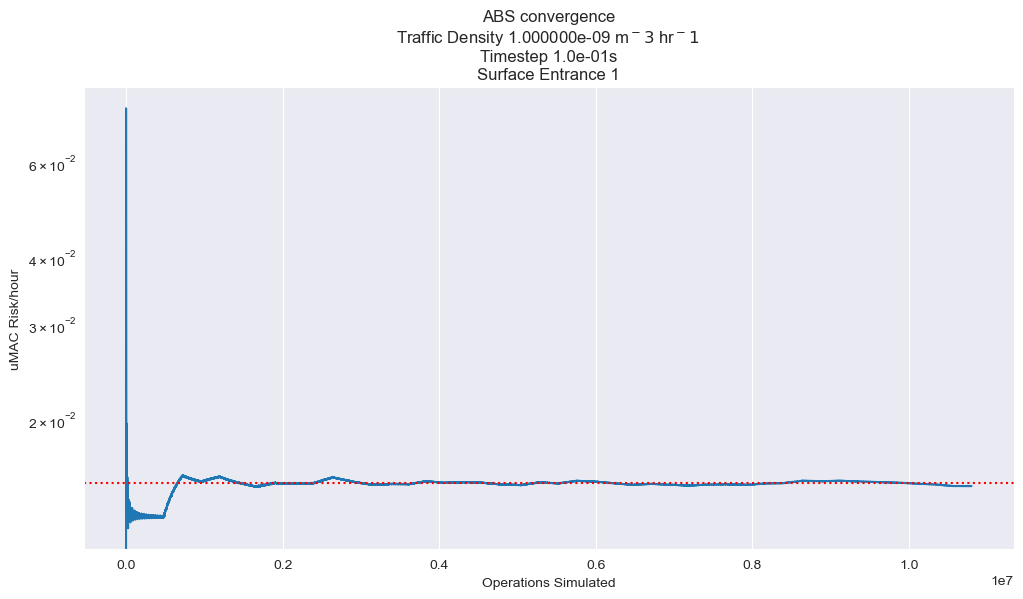

In [171]:
for db in glob(RESULT_DIR+'/QA-IoW-outputs/*.db'):
    filename = Path(db).stem
    print(db)
    run_config = run_config_cursor.execute(f'SELECT * FROM runs WHERE run_id="{filename}";').fetchone()
    _,_,_,traffic_density, timestep, surface_entrance, own_velocity = run_config

    dbcon = sqlite3.connect(db)
    dbcur = dbcon.cursor()
    res = dbcur.execute("SELECT * FROM sims").fetchall()
    sim_data = np.array(res, dtype=np.longlong)[:, 2:]
    sim_data = np.cumsum(sim_data, axis=0)
    n_sims = sim_data.shape[0]
    n_conflicts = sim_data[-1,1]
    sim_data = np.hstack((sim_data, (sim_data[:, 1] / (sim_data[:, 0]/3600))[:, None]))

    fig, ax = plt.subplots(
        1, 1, figsize=(12,6),
    )

    ax.plot(range(sim_data.shape[0]), sim_data[:, 2])
    ax.axhline(np.median(sim_data[:,2]), color='red', linestyle=':')
    # ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f"ABS convergence\nTraffic Density {traffic_density:1e} m$^{-3}$ hr$^{-1}$ \nTimestep {timestep:.1e}s\nSurface Entrance {surface_entrance}")
    ax.set_xlabel("Operations Simulated")
    ax.set_ylabel("uMAC Risk/hour")
    print(f'Traffic Density {traffic_density:1e} m$^{-3}$ hr$^{-1}$ \nTimestep {timestep:.1e}s\nSurface Entrance {surface_entrance} \nMedian uMAC rate {np.median(sim_data[:,2]):2e} per hour\n\n-----------------\n\n')

    conflict_sum = sim_data[:, 2].sum()
    sim_secs = (OWNPATH_PATH_LENGTH/70)*sim_data.shape[0]
    sim_hrs = sim_secs / (60*60)
    # sim_hrs = sim_data[:, 1].sum() / (60*60)
    sim_ops = sim_data.shape[0]
    mean_col_rate = conflict_sum / sim_hrs
    median_col_rate = np.median(sim_data[:,2])
    conv_metric = 1- (np.abs(np.diff(sim_data[-5000:,2]).sum())/median_col_rate)
    results.append([traffic_density, timestep, surface_entrance, sim_hrs, median_col_rate, conv_metric])

In [167]:
results

[[5e-12, 2.0, False, 27308.97327994302, 0.0, nan],
 [1e-13, 3.0, False, 822000.095726285, 0.0, nan],
 [1e-09, 0.1, 1, 2949369.1142338463, 0.015169828169690704, 0.9997978650141905]]

In [168]:
res_df = pd.DataFrame(results, columns=['traffic_density', 'timestep', 'surface_entrance', 'sim_hours', 'uMAC_per_hour', 'convergence']).dropna(axis=0)
# res_df = res_df[res_df['timestep'] <= 2]

In [169]:
corr = res_df.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/pandas/io/formats/style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,traffic_density,timestep,sim_hours,uMAC_per_hour,convergence
traffic_density,nan,nan,nan,nan,nan
timestep,nan,nan,nan,nan,nan
sim_hours,nan,nan,nan,nan,nan
uMAC_per_hour,nan,nan,nan,nan,nan
convergence,nan,nan,nan,nan,nan


In [63]:
density_groups = res_df.groupby('traffic_density')
density_group_means = density_groups['uMAC_per_hour'].mean()
density_group_stds = density_groups['uMAC_per_hour'].std()
density_group_means.index.values

array([1.e-15, 1.e-13, 1.e-12, 1.e-11, 5.e-11, 1.e-10, 1.e-09])

Text(0, 0.5, 'uMAC Risk/hour')

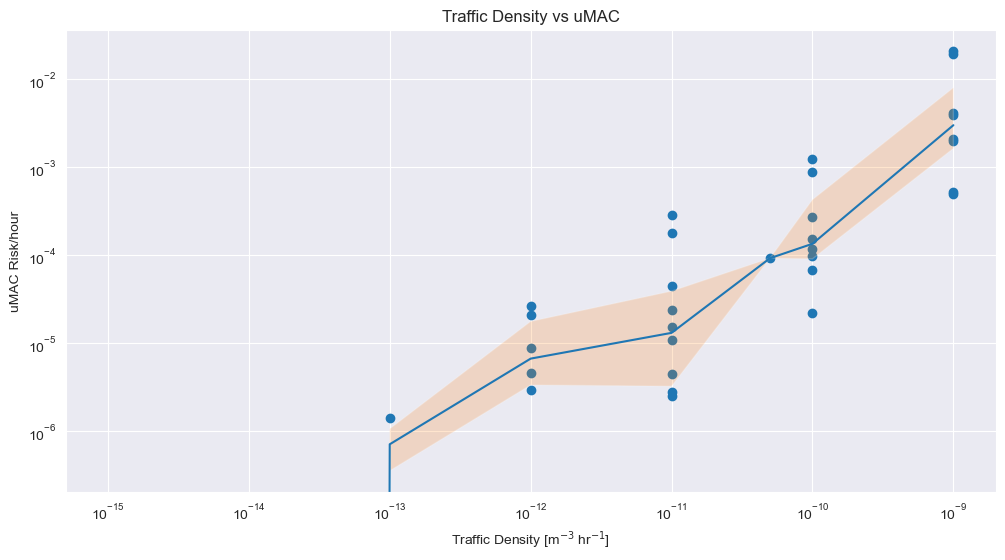

In [67]:

fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

ax.scatter(res_df['traffic_density'], res_df['uMAC_per_hour'])
density_group_means = density_groups['uMAC_per_hour'].mean()
ax.plot(density_groups['uMAC_per_hour'].median())
ax.fill_between(density_group_means.index.values, density_groups['uMAC_per_hour'].quantile(0.25), density_groups['uMAC_per_hour'].quantile(0.75), alpha=.2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Traffic Density vs uMAC')
ax.set_xlabel("Traffic Density [m$^{-3}$ hr$^{-1}$]")
ax.set_ylabel("uMAC Risk/hour")

Text(0, 0.5, 'uMAC Risk/hour')

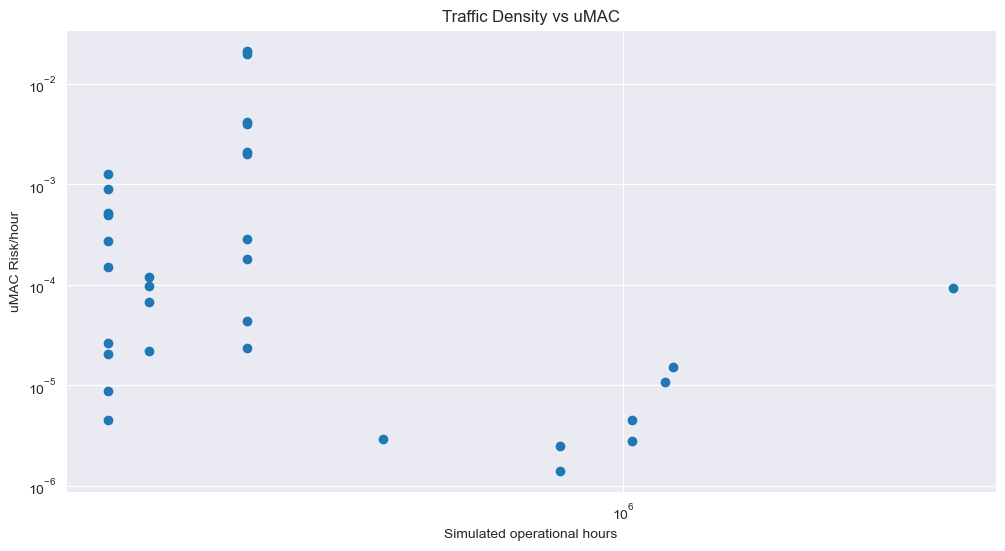

In [15]:
fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

ax.scatter(res_df['sim_hours'], res_df['uMAC_per_hour'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Simulated Hours vs uMAC')
ax.set_xlabel("Simulated operational hours")
ax.set_ylabel("uMAC Risk/hour")

Text(0, 0.5, 'uMAC Risk/hour')

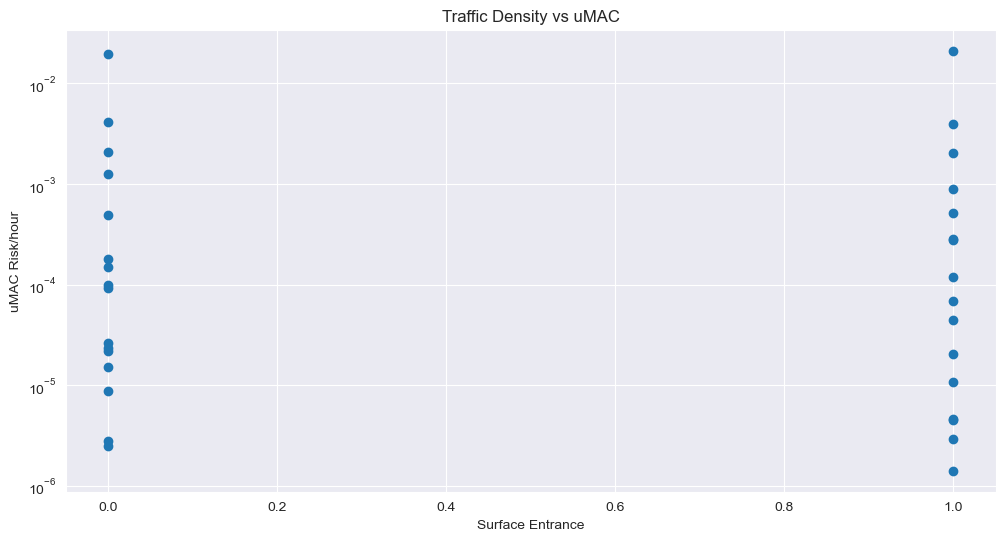

In [16]:
fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

ax.scatter(res_df['surface_entrance'], res_df['uMAC_per_hour'])
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Surface Entrance vs uMAC')
ax.set_xlabel("Surface Entrance")
ax.set_ylabel("uMAC Risk/hour")

Text(0, 0.5, 'uMAC Risk/hour')

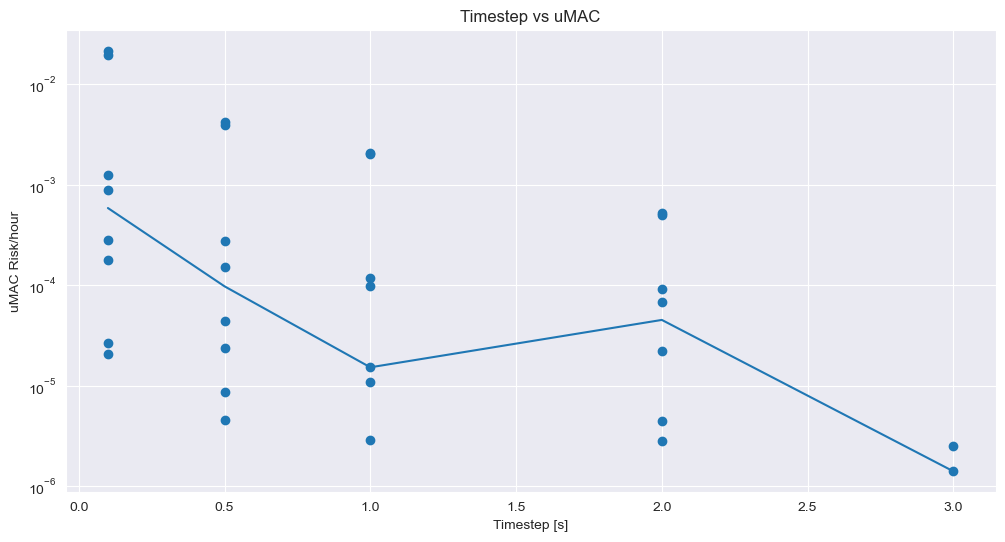

In [84]:
fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

ax.scatter(res_df['timestep'], res_df['uMAC_per_hour'])

ts_groups = res_df.groupby('timestep')
ts_group_means = density_groups['uMAC_per_hour'].mean()
ax.plot(ts_groups['uMAC_per_hour'].median())
# ax.fill_between(ts_group_means.index.values, ts_groups['uMAC_per_hour'].quantile(0.25), ts_groups['uMAC_per_hour'].quantile(0.75), alpha=.2)

# ax.set_xscale('symlog')
ax.set_yscale('log')
ax.set_title('Timestep vs uMAC')
ax.set_xlabel("Timestep [s]")
ax.set_ylabel("uMAC Risk/hour")

In [82]:
ts_groups['uMAC_per_hour'].quantile(0.25)

timestep
0.1    1.413029e-04
0.5    1.991543e-05
1.0    2.924291e-06
2.0    4.073051e-06
3.0    7.058712e-07
Name: uMAC_per_hour, dtype: float64